## Modules

In [103]:
import os
from tqdm import tqdm

import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, correlate, butter, freqs, filtfilt
from scipy.ndimage import gaussian_filter, median_filter, shift
from scipy.stats import sem
from signal_analysis import SignalAnalysis
from scipy.optimize import curve_fit
from WFmovie_mod import *

import tifffile as tff
import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt
from skimage.registration import phase_cross_correlation
import ants

cmap = 'cmc.batlow'
# sns.set_palette(cmap)

## Analysis Functions

### 2D analysis (time series)

In [144]:
def lowpass_filter2D(sig:list, cutoff:float=1, fs:float=10, order:int=5)->list:
    """lowpass filter easy to use for data

    Args:
        sig (list): 1D array of data (timeseries, flattenned frames)
        cutoff (float): cutoff frequency.  Defaults to 1
        fs (float, optional): sampling frequency. Defaults to 10.
        order (int, optional): order of the butter filter. Defaults to 5.

    Returns:
        list: filtered data
    """
    nyq = 0.5 * fs
    low = cutoff / nyq
    b, a = butter(order, low, btype='low')
    filtered_data = filtfilt(b, a, sig, axis=0)
    return filtered_data


def regress_drift2D(sig:list, time:list)-> list:
    """Prepares raw data to calculate HbO and HbR: removes 
        drift if any, and normalizes around 1

    Args:
        sig (list): 1D array containing signal
        time (list): 1D array containing time
        
    Returns:
        list: returns only the signal in a 1D array. Time is the same.
    """
    def droite(x, a, b):
        return a*x + b
    
    print("Global regression")
    popt, pcov = curve_fit(droite, time, sig)
    pcov = None
    sig_r = sig/droite(time, *popt)

    return sig_r

In [145]:
def prepToCompute2D(sig:list, time:list, filter=False, cutoff:float=1, regress=True):
    """_summary_

    Args:
        sig (list): 1D array of signal (timeseries)
        time (list): 1D array of time associated with sig. Must be same length
        filter (bool, optional): lowpass filter. Defaults to False.
        cutoff (float, optional): cutoff frequency for lowpass filter. Defaults to 1.
        regress (bool, optional): linear regression for LED drift. Centers data around 1. Defaults to True.

    Returns:
        _type_: 1D array of sig
    """
    if filter:
        sig = lowpass_filter2D(sig, cutoff)

    if regress:
        sig = regress_drift2D(sig, time)

    return sig

def convertToHb2D(data_green, data_red):
    """converts green and red signals to Hb variation in tissue

    Args:
        data_green (list): preprocessed green timeseries
        data_red (list): preprocessed red timeseries

    Returns:
        list: 2D array (d_HbO, d_HbR) 
    """
    lambda1 = 450 #nm
    lamba2 = 700 #nm
    npoints = 1000
    baseline_hbt = 100 #uM
    baseline_hbo = 60 #uM
    baseline_hbr = 40 #uM
    rescaling_factor = 1e6
    
    eps_pathlength = ioi_epsilon_pathlength(lambda1, lamba2, npoints, baseline_hbt, baseline_hbo, baseline_hbr, filter=None)
    Ainv = np.linalg.pinv(eps_pathlength)*rescaling_factor
    ln_green = -np.log(data_green.flatten())
    ln_red = -np.log(data_red.flatten())
    ln_R = np.concatenate((ln_green.reshape(1,len(ln_green)),ln_red.reshape(1,len(ln_green))))
    Hbs = np.matmul(Ainv, ln_R)
    d_HbO = Hbs[0].reshape(np.shape(data_green))
    d_HbR = Hbs[1].reshape(np.shape(data_green))
    # Protection against aberrant data points
    np.nan_to_num(d_HbO, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    np.nan_to_num(d_HbR, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
    return d_HbO, d_HbR


def dHb_pipeline2D(data_path, save_path, filter=False, cutoff=0.2, regress=True):
    """pipeline to compute Hb from raw data. Data must the sorted first, see data_path arg.

    Args:
        data_path (string): path of the raw data. Data must be sorted first with the 'splitChannels.py' script, 
        and timestamps extracted with 'extract_ts_moment.py'
        save_path (string): path of folder where computed data must be saved
        filter (bool, optional): lowpass time filter. Defaults to False.
        cutoff (float, optional): cutoff frequency if filter used. Defaults to 0.2.
        regress (bool, optional): linear regression to remove LED drift and center data around 1. Defaults to True.
    """
    # process green
    green = np.loadtxt(data_path + "\\csv\\530.csv", skiprows=1, delimiter=',')[:,1]
    green_t = np.load(data_path + "\\530ts.npy")
    print("Green data loaded")
    green = prepToCompute2D(green, green_t, filter, cutoff, regress)
    np.save(data_path + "\\530preped.npy", green)
    green = None
    print("Green data saved")

    # process red    
    red = np.loadtxt(data_path + "\\csv\\625.csv", skiprows=1, delimiter=',')[:,1]
    red_t = np.load(data_path + "\\625ts.npy")
    print("Red data loaded")
    red = prepToCompute2D(red, red_t, filter, cutoff, regress)
    np.save(data_path + "\\625preped.npy", red)
    red = None
    print("Red data saved")

    # convert to hb
    print("Convert to dHb")
    green = np.load(data_path + "\\530preped.npy")
    red = np.load(data_path + "\\625preped.npy")
    d_HbO, d_HbR = convert_to_hb(green, red)
    Hb = np.array((d_HbO, d_HbR, d_HbO+d_HbR))

    # save processed data
    np.save(save_path + "\\computedHb.npy", Hb)
    print("Done")

### 3D analysis (frames)

In [128]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files.sort()
    return files


def motion_correction(frames):
    """Applies motion correction based on a phase cross correlation

    Args:
        frames (_type_): 3D array of frames before correction

    Returns:
        _type_: 3D array of frames after correction
    """
    fixed_frame = frames[0,:,:]
    motion_corrected = np.zeros((frames.shape), dtype=np.uint16)
    for idx, frame in tqdm(enumerate(frames)):
        if idx == 0:
            motion_corrected[0,:,:] = frame
            continue
        shifted, error, diffphase = phase_cross_correlation(fixed_frame, frame, upsample_factor=10)
        corrected_image = shift(frame, shift=(shifted[0], shifted[1]), mode='reflect')
        motion_corrected[idx,:,:] = corrected_image
    
    shifted, error, diffphase, corrected_image, fixed_frame = None, None, None, None, None
    return motion_corrected


def bin_pixels(frame, bin_size):
    height, width = frame.shape[:2]
    binned_height = height // bin_size
    binned_width = width // bin_size

    reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)
    binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
    binned_frame = binned_frame / (bin_size**2)

    height, width, binned_height, binned_width, reshaped_frame = None, None, None, None, None
    return binned_frame

def lowpass_filter(sig:list, cutoff:float=1, fs:float=10, order:int=5)->list:
    """lowpass filter easy to use for data

    Args:
        sig (list): 1D array of data (timeseries, flattenned frames)
        cutoff (float): cutoff frequency.  Defaults to 1
        fs (float, optional): sampling frequency. Defaults to 10.
        order (int, optional): order of the butter filter. Defaults to 5.

    Returns:
        list: filtered data
    """
    nyq = 0.5 * fs
    low = cutoff / nyq
    b, a = butter(order, low, btype='low')
    filtered_data = filtfilt(b, a, sig, axis=0)
    return filtered_data


def regress_drift(sig:list, time:list, save_path, wl:int=530)-> list:
    """Prepares raw data to calculate HbO and HbR: removes 
        drift if any, and normalizes around 1

    Args:
        sig (list): 1D array containing signal
        time (list): 1D array containing time
        wl (int): wavelength of light corresponding to data, necessary for saving data as npy. Defaults to 530
        filter (bool): activate Defaults to False
        
    Returns:
        list: returns only the signal in a 1D array. Time is the same.
    """
    def droite(x, a, b):
        return a*x + b
    
    print("Global regression")
    popt, pcov = curve_fit(droite, time, sig)
    pcov = None
    sig_r = sig/droite(time, *popt)

    return sig_r


In [127]:
def prepToCompute(sig:list, time:list, wl:int=530, motion_correction=False, filter=False, cutoff:float=1, bin_size=None, regress=False):
    # passer motion correction, bin, lowpass, regress
    pass

def convertToHb(data_green, data_red):
    lambda1 = 450 #nm
    lamba2 = 700 #nm
    npoints = 1000
    baseline_hbt = 100 #uM
    baseline_hbo = 60 #uM
    baseline_hbr = 40 #uM
    rescaling_factor = 1e6
    
    eps_pathlength = ioi_epsilon_pathlength(lambda1, lamba2, npoints, baseline_hbt, baseline_hbo, baseline_hbr, filter=None)
    Ainv = np.linalg.pinv(eps_pathlength)*rescaling_factor
    ln_green = -np.log(data_green.flatten())
    ln_red = -np.log(data_red.flatten())
    ln_R = np.concatenate((ln_green.reshape(1,len(ln_green)),ln_red.reshape(1,len(ln_green))))
    Hbs = np.matmul(Ainv, ln_R)
    d_HbO = Hbs[0].reshape(np.shape(data_green))
    d_HbR = Hbs[1].reshape(np.shape(data_green))
    # Protection against aberrant data points
    np.nan_to_num(d_HbO, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    np.nan_to_num(d_HbR, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    
    return d_HbO, d_HbR


def dHb_pipeline(data_path, save_path, motion_correction=False, bin_size=None, filter=False, cutoff=0.2, regress=False):
    # pathBase = folder_path  #r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"
    # os.chdir(pathBase)

    # process green
    # open data, prep, save data
    green = np.loadtxt(data_path + "\\csv\\530.csv", skiprows=1, delimiter=',')[:,1]
    green_t = np.load(data_path + "\\530ts.npy")
    print("Green data loaded")
    prepToCompute(green, green_t, save_path=data_path, wl=530, filter=filter, cutoff=cutoff)
    green = np.load(data_path + "\\530preped.npy")
    # C:\Users\gabri\Documents\Université\Maitrise\Projet\Widefield-Imaging-Acquisition\530preped.npy

    # process red    
    red = np.loadtxt(data_path + "\\csv\\625.csv", skiprows=1, delimiter=',')[:,1]
    red_t = np.load(data_path + "\\625ts.npy")
    print("Red data loaded")
    prepToCompute(red, red_t, save_path=data_path, wl=625, filter=filter, cutoff=cutoff)
    red = np.load(data_path + "\\625preped.npy")

    # convert to hb
    print("Convert to dHb")
    d_HbO, d_HbR = convert_to_hb(green, red, save_path)

    # save processed data
    # fig = plt.figure(figsize=(10,5))
    # plt.plot(green_t, d_HbO, 'r-')
    # plt.plot(red_t, d_HbR, 'b-')
    # plt.plot(red_t, d_HbO+d_HbR, 'g-')
    # plt.xlim(0, 100)

    print("Done")


## Open data

In [135]:
pathBase = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"

# raw
green = np.loadtxt(pathBase + "\\csv\\530.csv", skiprows=1, delimiter=',')[:,1]
red = np.loadtxt(pathBase + "\\csv\\625.csv", skiprows=1, delimiter=',')[:,1]

green_t = np.load(pathBase + "\\530ts.npy")
red_t = np.load(pathBase + "\\625ts.npy")

# prepped

## AP time series

In [4]:
FPS = 50
AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(green_t)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(green_t-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(green_t))
AP_series[AP_idx] = 1

## Quick plot

(0.0, 100.0)

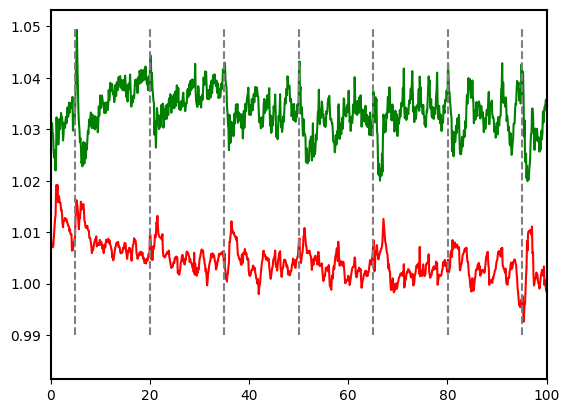

In [5]:
plt.plot(red_t, red/np.mean(red), 'r-')
plt.plot(green_t, green/np.mean(green)+0.03, 'g-')
plt.vlines(red_t[AP_idx], 0.99, 1.05, colors='grey', linestyles='--')
plt.xlim(0, 100)
# plt.savefig('red_600zoomed.png', dpi=600)

## Function testing

In [141]:
test = True
if test:
    data_path = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"
    save_path = data_path
    dHb_pipeline2D(data_path, save_path, filter=True, regress=True)


(3, 2593)


## Tests avec tiff

In [82]:
# load data

data_path = r"Y:\gGermain\2024-07-18\530_stackraw.npy"
save_path = data_path

frames = np.load(data_path)
frames = frames[:10,:,:]


10it [00:04,  2.14it/s]


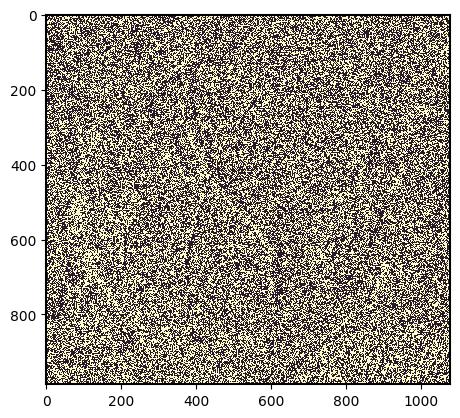

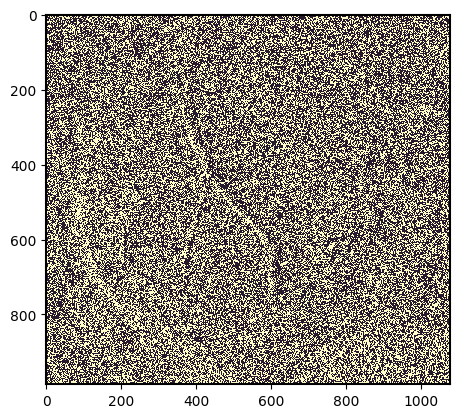

In [124]:
# data_path = r"Y:\gGermain\2024-07-18"
# save_path = data_path

# # create 3d array from stack
# files = identify_files(data_path+"\\530", "tif")
# files=files[:250]
# for idx, file in tqdm(enumerate(files)):
#     frame = tff.TiffFile(data_path+"\\530\\"+file).asarray()
#     if idx == 0:
#         num_frames = len(files)
#         frame_shape = frame.shape
#         stack_shape = (num_frames, frame_shape[0], frame_shape[1])
#         _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
#     _3d_stack[idx,:,:] = frame

# np.save(save_path+"\\530_stackraw.npy", _3d_stack)


## motion correction with antspy

# motion_corrected = np.zeros((frames.shape), dtype=np.uint8)
# fixed_frame = ants.from_numpy(frames[0,:,:])
# for idx, frame in tqdm(enumerate(frames)):
#     frame = ants.from_numpy(frame)
#     corected_frame =  ants.registration(fixed_frame, frame)['warpedmovout']
#     motion_corrected[idx,:,:] = corected_frame.numpy()
# plt.imshow(motion_corrected[1,:,:] - motion_corrected[-1,:,:])
    

## motion correction with skimage

fixed_frame = frames[0,:,:]

motion_corrected = np.zeros((frames.shape), dtype=np.uint16)

for idx, frame in tqdm(enumerate(frames)):
    if idx == 0:
        continue
    shifted20, error, diffphase = phase_cross_correlation(fixed_frame, frame, upsample_factor=5)
    corrected_image20 = shift(frame, shift=(shifted20[0], shifted20[1]), mode='reflect')
    # motion_corrected[idx,:,:] = corrected_image
    shifted10, error, diffphase = phase_cross_correlation(fixed_frame, frame, upsample_factor=10)
    corrected_image10 = shift(frame, shift=(shifted10[0], shifted10[1]), mode='reflect')

# plt.imshow(frame - fixed_frame)
# plt.show()
# plt.imshow(corrected_image - fixed_frame)
# plt.show()
plt.imshow(corrected_image10 - frame)
plt.show()
plt.imshow(corrected_image20 - frame)






## Correlation avec HbO HbR

In [8]:
correlation = correlate(AP_series, HbO*-1+2e-5)
lag = np.argmax(correlation)
print('lag:', (len(red_t) - lag)*1/10, 's')
plt.plot(correlation)
correlation = correlate(AP_series, HbR*-1+2e-5)
lag = np.argmax(correlation)
print('lag:', (len(red_t) - lag)*1/10, 's')
plt.plot(correlation)

NameError: name 'HbO' is not defined